#**2. Exploratory Data Analysis**

## **Imports**

In [ ]:
from google.colab import auth
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/drive')
!pip install wbgapi
!pip install pandasql
!pip install yfinance
!pip install scikit-posthocs
#import packages
from pandasql import sqldf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
import wbgapi as wb
import os
import datetime as dt
from sklearn.preprocessing import scale
from pandas.plotting import lag_plot
#set style for plots
sns.set_theme(style="whitegrid", palette='deep')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##**2.1. Loading Data**

In [ ]:
url = '/content/drive/MyDrive/Springboard/Capstone3/daily_sales_agg.csv'
df = pd.read_csv(url)

In [ ]:
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

In [ ]:
df = df[df.date < '2017-08-16']

In [ ]:
#imput NaN
df['sales'] = df['sales'].fillna(method = 'ffill')

In [ ]:
df.index = df['date']

In [ ]:
df.drop('date', axis = 1, inplace = True)

In [ ]:
df['value_per_transaction'] = df.sales/df.transactions

In [ ]:
df.head()

,exxon_price,oil,CPI,GDPPCAP,POP,transactions,sales,day_off,locale,salary_day,year,month,quarter,value_per_transaction
date,,,,,,,,,,,,,,
2013-01-01,58.550953,93.14,2.721776,6056.331213,15707473.0,770.0,2511.618999,1,3,False,2013,1,1,3.261843
2013-01-02,58.550953,93.14,2.721776,6056.331213,15707473.0,93215.0,496092.417944,0,0,False,2013,1,1,5.322023
2013-01-03,58.445324,92.97,2.721776,6056.331213,15707473.0,78504.0,361461.231124,0,0,False,2013,1,1,4.604367
2013-01-04,58.715935,93.12,2.721776,6056.331213,15707473.0,78494.0,354459.677093,0,0,False,2013,1,1,4.515755
2013-01-05,58.715935,93.12,2.721776,6056.331213,15707473.0,93573.0,477350.121229,0,0,False,2013,1,1,5.101366


##**2.2. Changes in sales**

###**2.2.1. Daily Trend**

In [ ]:
# Plot the daily change in sales 
import plotly.express as px

fig = px.line(df, x=df.index, y=['sales'], title='Change in sales between 2013-2017',
              labels = {'value':'dollars', 'date':'Years', 'variable':'sales'})
fig.update_xaxes(rangeslider_visible=True, rangeslider_thickness = 0.1)

fig.update_layout(
    title={
        'text': "Change in sales between 2013-2017",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

As seen in figure:

* There is an upward trend in the data over this period. Sales in 2013 started around 0.5M, gradually grew to 1M in 2017
* There is an intuition about seasonality, but examining the data monthly and quarterly is more helpful.
* Sales tend to decrease after the beginning of years and also increase towards the end of the year. It could be examined by montly analysis.
* There are some spikes in earlies of 2014, middle of 2014, and early 2016.

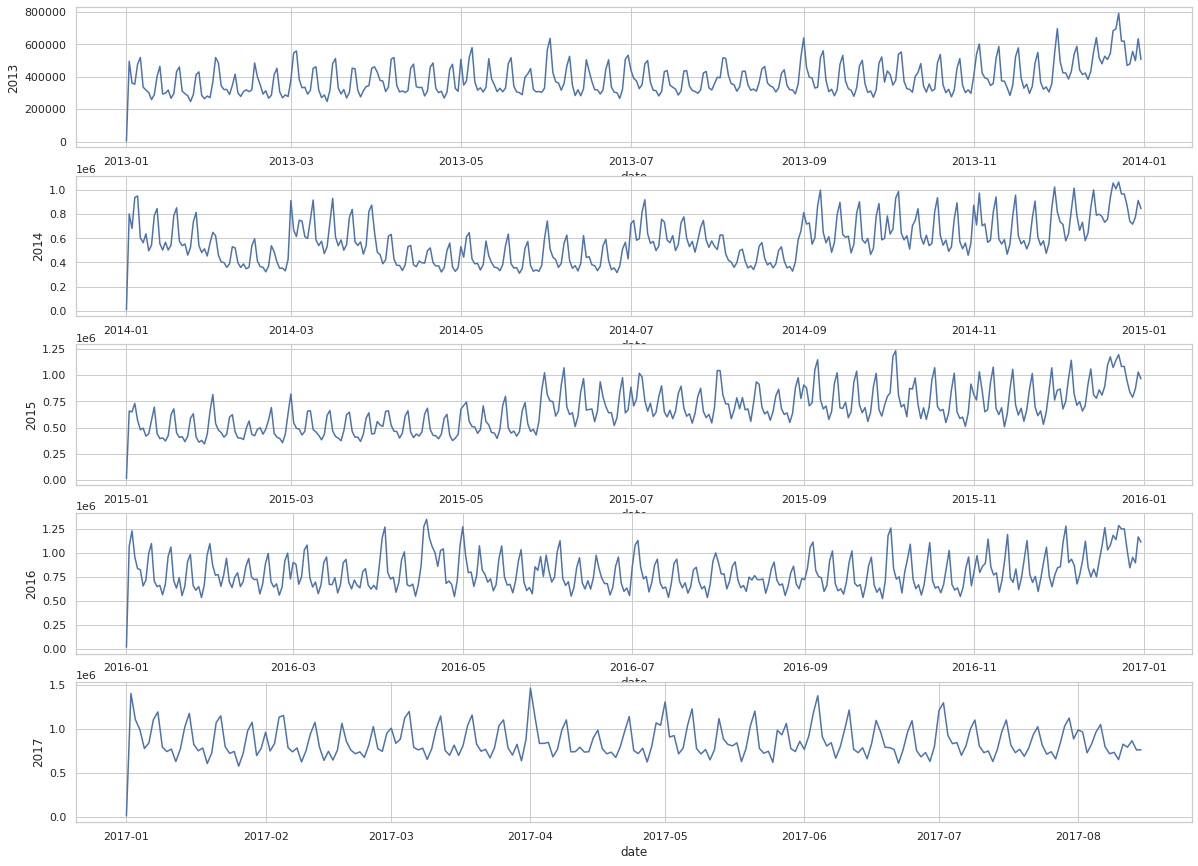

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime as dt
# Daily changes in sales according to each year.
fig, ax = plt.subplots(nrows=5, ncols=1,figsize=(20, 15))
for i in  df.year.unique():
  df_year =  df[df.year == i]
  sns.lineplot(data=df_year, x='date', y='sales', ax=ax[i-2013])
  ax[i-2013].set_ylabel(i, fontsize = 12)

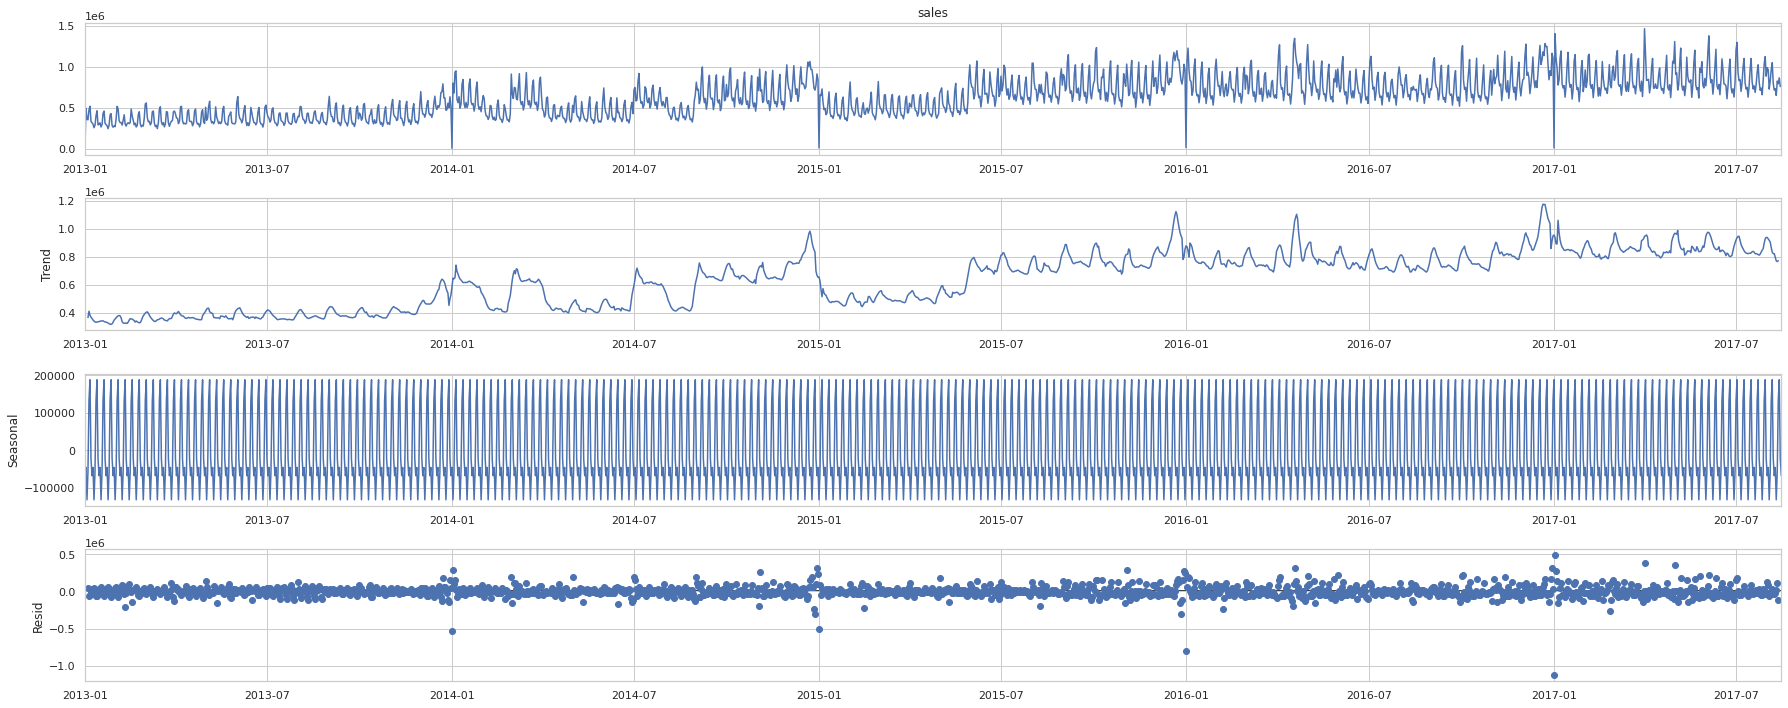

In [ ]:
# Additive decomposition of daily data

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df.sales)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual =  decomposition.resid

plt.rcParams.update({'figure.figsize': (25,10)})
decomposition.plot()
plt.show()



*   Decomposition of daily data doesn't really help the interpretation. This will be examined by monthly and quarterly data.



###**2.2.2. Weekly Trend**

In [ ]:
# Descriptive statistics of days

# create a new column for days of week.
df['week_days'] = df.index.weekday 

# Create pivot table
table = pd.pivot_table(data=df, 
                        index=['week_days'], 
                        values='sales',
                        aggfunc=['mean', 'max', 'min', 'std'])

# two level of columns. Drop one of them
table.columns = table.columns.droplevel(1)

#rename a new column for days
table['days'] = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

#change index
table = table.set_index('days')
table = table/1000

table.T

days,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
mean,617.542713,569.926088,593.358324,507.180876,581.666087,772.205594,826.967581
max,1402.306371,1152.089208,1196.146056,1135.849391,1282.145517,1463.083962,1376.511520
min,278.627589,2.511619,8.602065,12.773617,16.433394,403.258212,12.082501
std,202.901446,199.672002,206.551914,170.922350,194.241207,221.747538,258.367361


[Text(0, 0.5, 'Sales (thousands)'), Text(0.5, 0, 'Days of Week')]

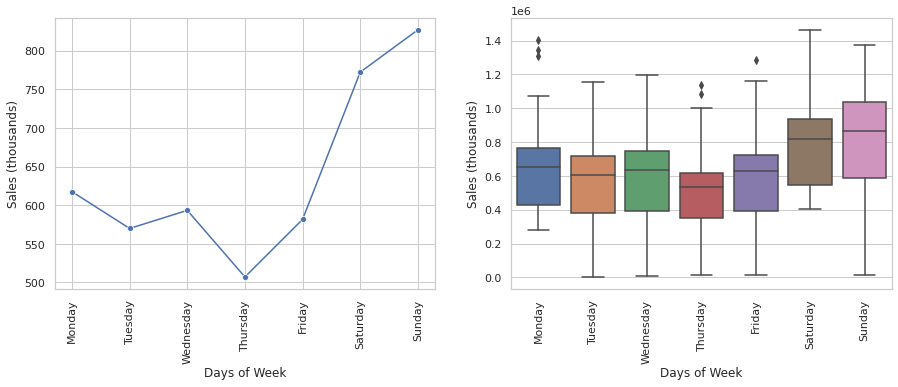

In [ ]:
# line and box plot for pm2.5 according to the days of week 
f, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(x= table.index, y= 'mean' , data=table, ax=axes[0], marker='o')
sns.boxplot(x='week_days', y='sales', data=df, ax=axes[1])

days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
axes[0].set_xticklabels(days, rotation=90) 
axes[1].set_xticklabels(days, rotation=90) 
axes[0].set(xlabel='Days of Week', ylabel='Sales (thousands)')
axes[1].set(xlabel='Days of Week', ylabel='Sales (thousands)')

* Sales tend to increase from Thursday to Sunday.
* Thursday has the lowest  average (510) , Sunday has the highest  average (826). 
* Weekday vs. Weekend significantly influence the daily sales

In [ ]:
# Is there a statistically difference between days?

# check normality

from scipy.stats import normaltest

# normality test
stat, p = normaltest(df.sales)

print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05

if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=51.521, p=0.000
Sample does not look Gaussian (reject H0)


In [ ]:
# import
import scipy.stats as ss

# Non-parametric Kruskal-Wallis H test
data = [df.loc[ids, 'sales'].values for ids in df.groupby('week_days').groups.values()]

H, p = ss.kruskal(*data)
alpha = 0.05

if p > alpha:
	print('population means of all groups are equal (fail to reject H0)')
else:
	print('population means of all groups are not equal (reject H0)')

population means of all groups are not equal (reject H0)


Therefore, there is a statistically difference between weekday and weekend sales

###**2.2.3. Monthly Trend**

In [ ]:
# I want to see sales change according to the months.

# Descriptive statistics
table_m = pd.pivot_table(data=df, 
                        index=['month'], 
                        values='sales',
                        aggfunc=['mean', 'max', 'min', 'std'])

# two level of columns. Drop of them
table_m.columns = table_m.columns.droplevel(1)

# Create a new columns for months
table_m['months'] = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Set index 
table_m = table_m.set_index('months')
table_m = table_m/1000
table_m.T

months,January,February,March,April,May,June,July,August,September,October,November,December
mean,609.304208,571.895244,627.280562,604.454117,609.026690,630.111355,666.858456,600.520697,645.613999,645.809509,669.464901,814.072622
max,1402.306371,1151.987631,1196.983690,1463.083962,1306.699367,1376.511520,1296.379218,1049.559164,1147.642583,1256.480171,1188.982232,1282.145517
min,2.511619,267.711109,247.541420,268.790619,289.261058,266.525459,281.750931,294.518686,273.057880,276.059080,284.567403,384.256081
std,268.236797,219.403982,217.025088,261.373166,241.142625,227.399443,214.114782,200.249198,208.425895,224.283454,215.148327,228.325907


[Text(0, 0.5, 'sales(thousands'), Text(0.5, 0, 'Months')]

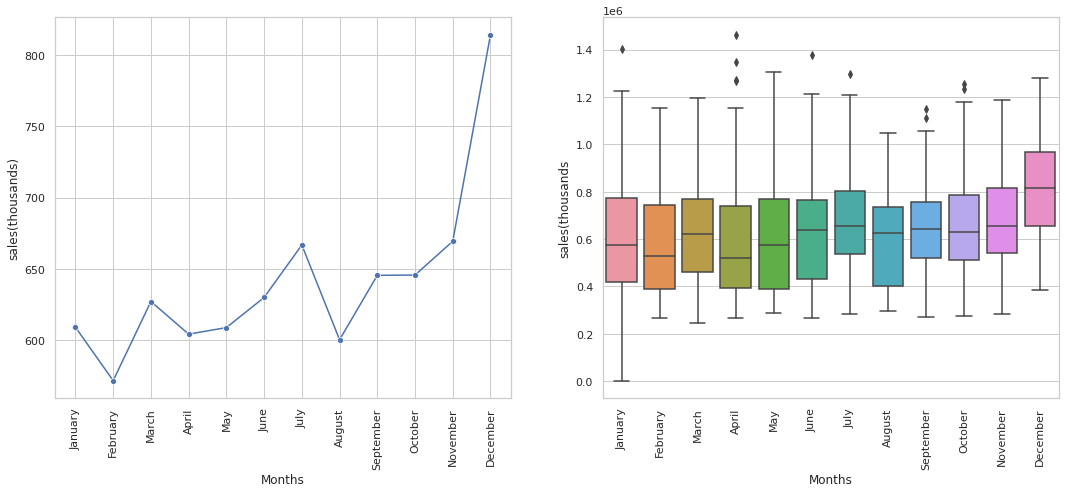

In [ ]:
# line and box plot for pm2.5 according to months
f, ax = plt.subplots(1, 2, figsize=(18, 7))
sns.lineplot(x = table_m.index , y= 'mean' , data=table_m, ax=ax[0], marker='o')
sns.boxplot(x='month', y='sales', data=df, ax=ax[1])
ax[0].set_xticklabels(table_m.index, rotation=90)
ax[1].set_xticklabels(table_m.index, rotation=90) 
ax[0].set(xlabel='Months', ylabel='sales(thousands)')
ax[1].set(xlabel='Months', ylabel='sales(thousands')

* Upward trending through out the year
* 3 peaks: March, July, and December
* April have the most number of outliers 

In [ ]:
# Sales values doesn't distributed normally
# Non-parametric Kruskal-Wallis H test
data = [df.loc[ids, 'sales'].values for ids in df.groupby('month').groups.values()]

H, p = ss.kruskal(*data)
alpha = 0.05

if p > alpha:
	print('population means of all groups are equal (fail to reject H0)')
else:
	print('population means of all groups are not equal (reject H0)')

# We may reject the null hypothesis that the population medians of all of the groups are equal. 

population means of all groups are not equal (reject H0)


In [ ]:
import scipy.stats as ss
import statsmodels.api as sa
import scikit_posthocs as sp

sp.posthoc_conover(df, val_col='sales', group_col='month', p_adjust = 'holm').round()

# There is statistical significant difference between months.

,1,2,3,4,5,6,7,8,9,10,11,12
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
5,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
7,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
9,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


* Jan -- Dec
* Feb -- Jul, Sep, Nov, Dec
* Mar -- Dec
* Apr -- Jul, Dec
* May -- Dec
* Jun -- Dec
* Jul -- Feb, Apr, Dec
* Aug -- Dec
* Sep -- Feb, Dec
* Oct -- Dec
* Nov -- Feb, Apr, Dec
* Dec -- All other months 

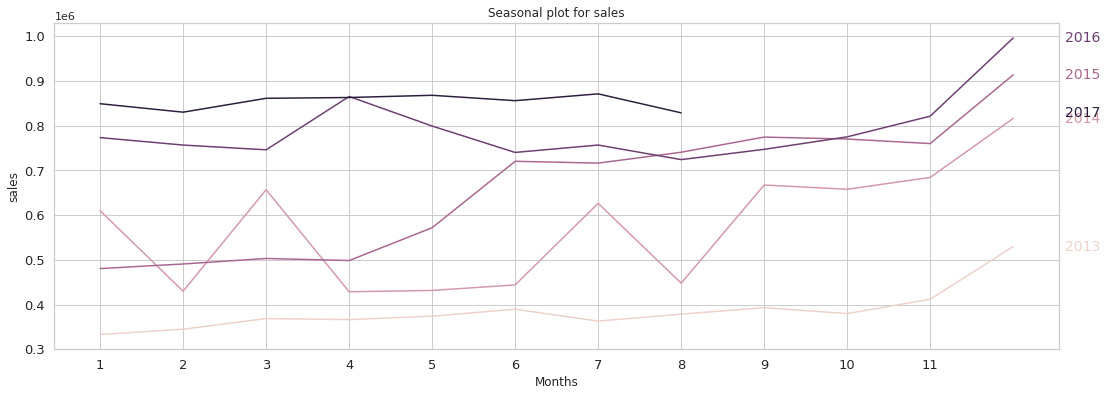

In [ ]:
# Seasonal plot
plt.figure(figsize=(18,6))
plt.xticks(np.arange(1, 12, 1.0), fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Months')
plt.ylabel('sales')
ax= sns.lineplot(data=df, 
             x='month', 
             y='sales', 
             hue='year', 
             legend=None,
             ci= None,
             markers=True)
# add title
plt.title('Seasonal plot for sales')

# add years at the end of line
for line, name in zip(ax.lines, [2013,2014,2015,2016,2017]):
    y = line.get_ydata()[-1]
    ax.annotate(name, xy=(1,y), xytext=(6,0), color=line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=14, va="center")

plt.show()

* There is a peak in Apr 2016 caused by the earth quake 
* The peak in Dec are consistent throughout 

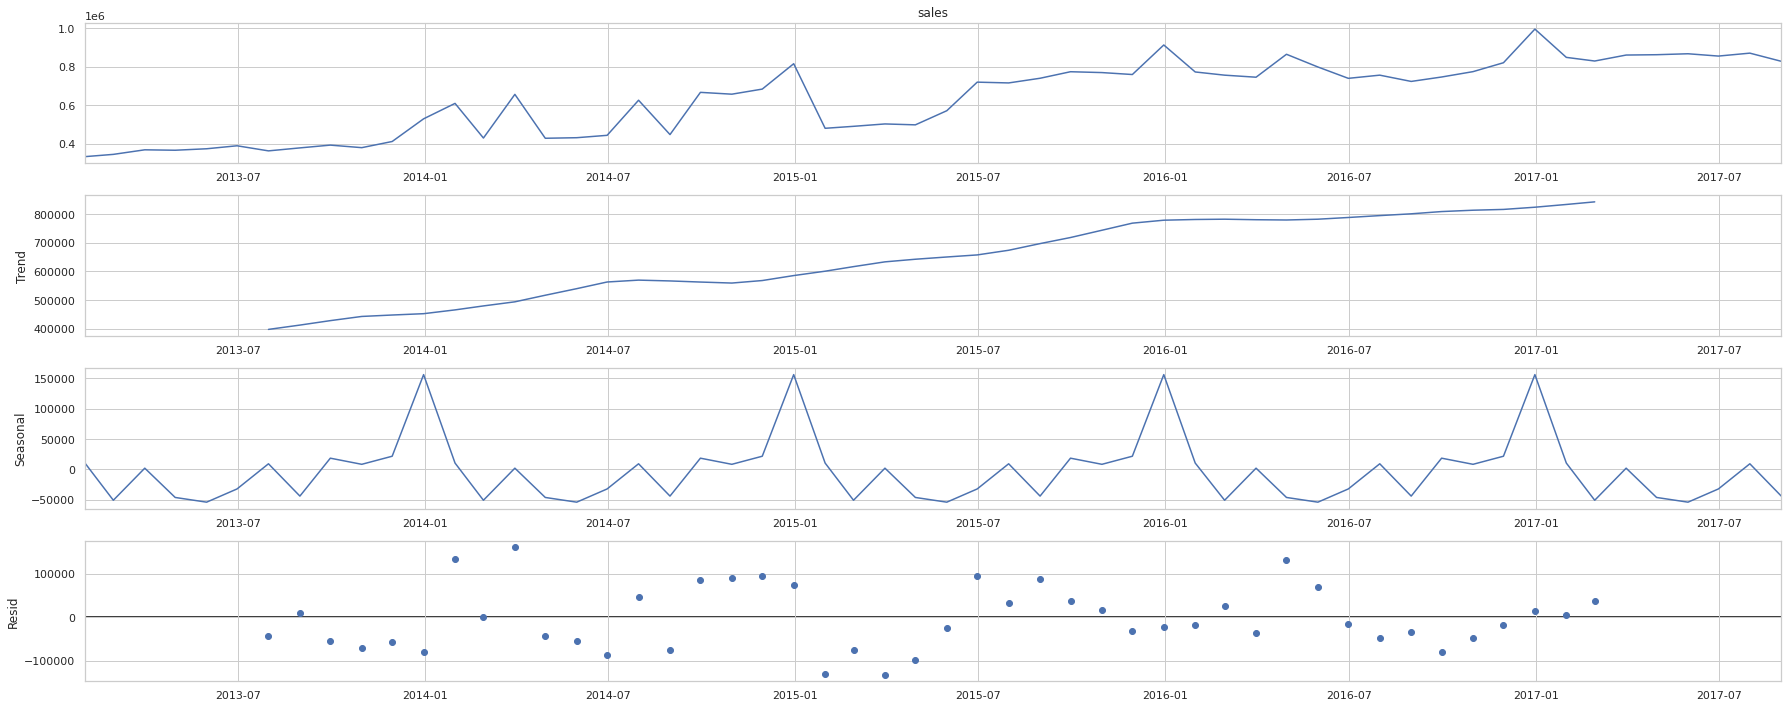

In [ ]:
# Monthly decomposition

# Resample dataframe monthly
df_monthly = df.resample(rule='M').mean()


decomposition = seasonal_decompose(df_monthly.sales)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual =  decomposition.resid

plt.rcParams.update({'figure.figsize': (25,10)})
decomposition.plot()
plt.show()

There is a clear seasonal trend for monthly data

###**2.2.4. Quarterly Trend**

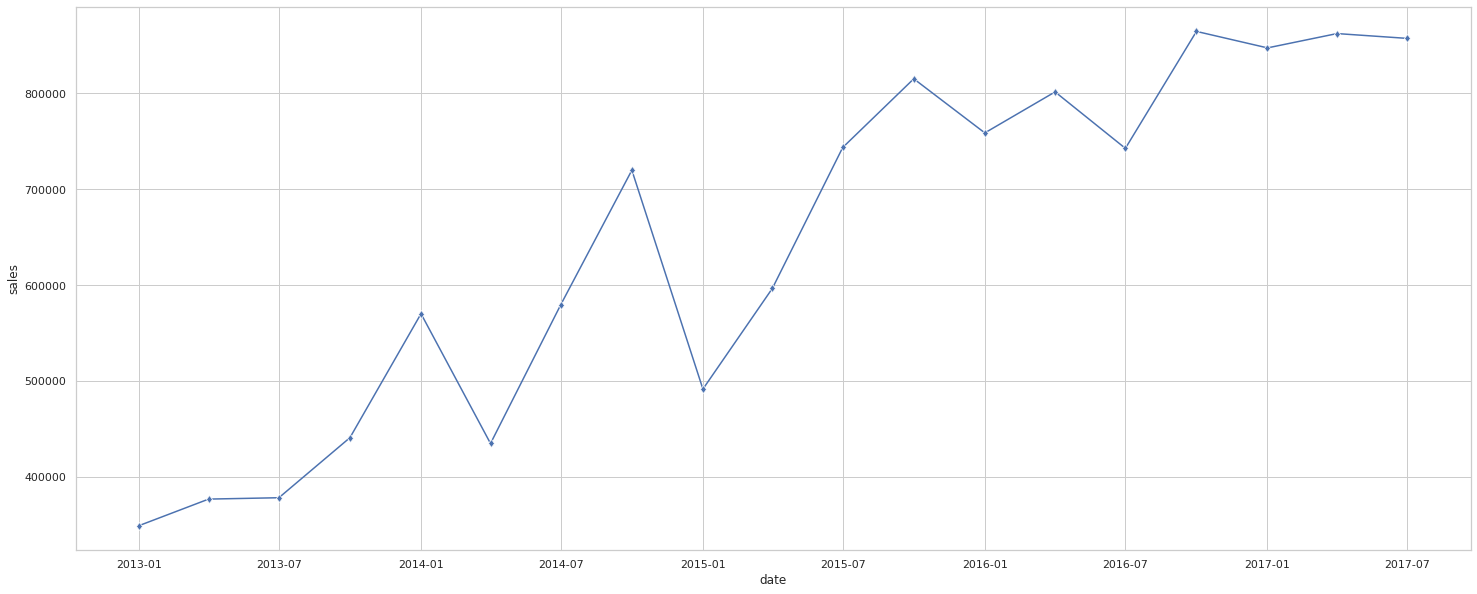

In [ ]:
# Create a new dataframe for quarterly data
df_quarterly = df.resample(rule='QS').mean()
sns.lineplot(x = df_quarterly.index , y='sales' , data=df_quarterly , marker='d')

* There are consistent upward trend from Q2 through Q4 except for 2016 when the earth quake happened that increased the sales of Q2 


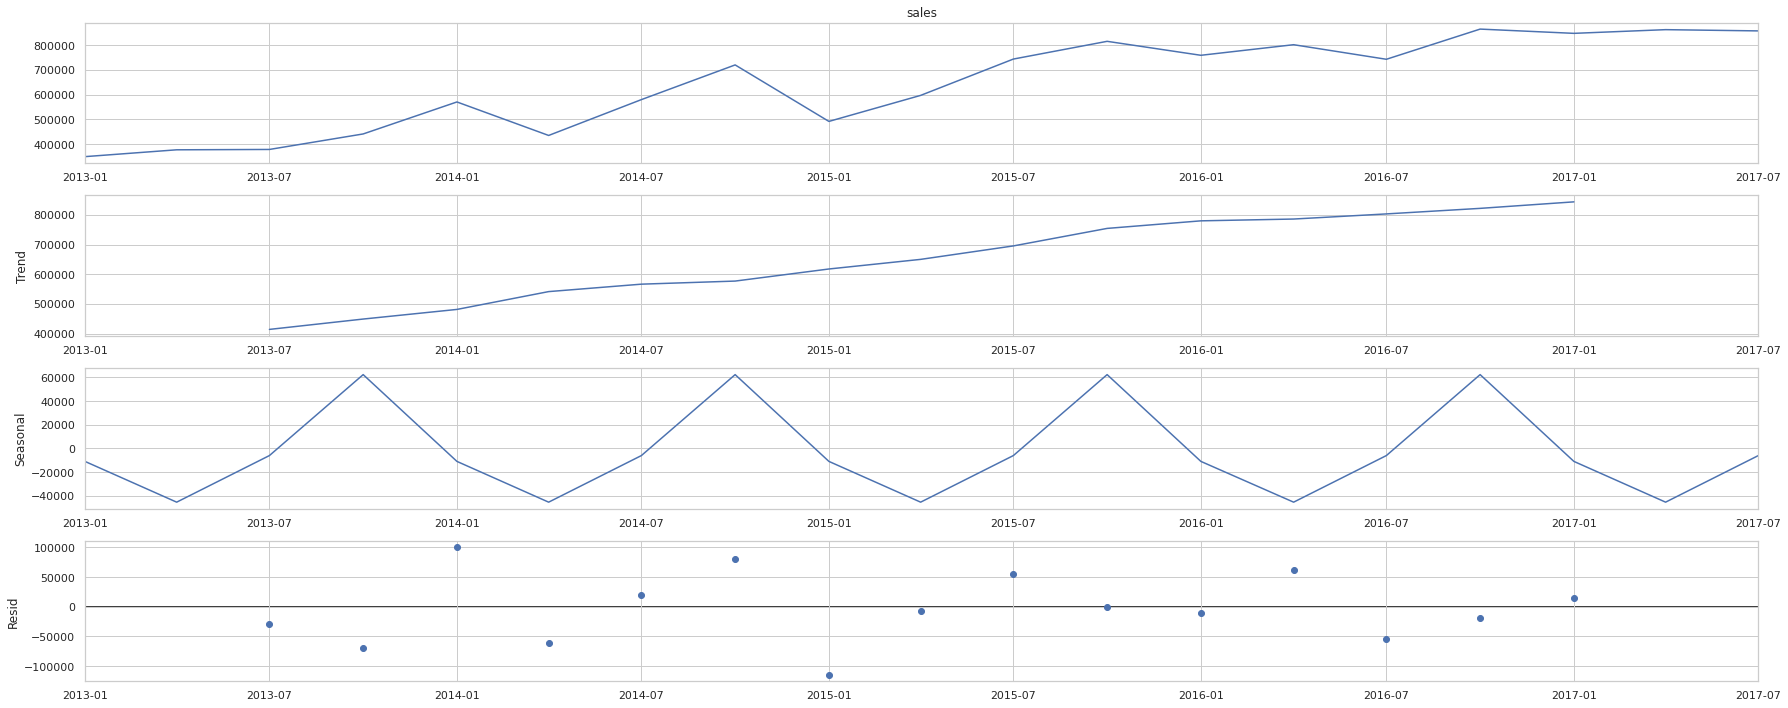

In [ ]:
# Quarterly decomposition

decomposition = seasonal_decompose(df_quarterly.sales)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual =  decomposition.resid

plt.rcParams.update({'figure.figsize': (25,10)})
decomposition.plot()
plt.show()

###**2.2.5. Annual Trend**

In [ ]:
# Create a new dataframe for annual data
df_annual = df.resample(rule='A').mean()

In [ ]:
table_y = pd.pivot_table(data=df, 
                        index=['year'], 
                        values='sales',
                        aggfunc=['mean', 'max', 'min', 'std'])

# two level of columns. Drop of them
table_y.columns = table_y.columns.droplevel(1)
table_y = (table_y/1000)
table_y.T

year,2013,2014,2015,2016,2017
mean,386.410075,576.548573,662.914468,792.080221,855.581799
max,792.865284,1064.977973,1234.130939,1345.920605,1463.083962
min,2.511619,8.602065,12.773617,16.433394,12.082501
std,97.900972,179.437728,198.463444,182.310060,180.137967


[Text(0, 0.5, 'sales (thousands)'), Text(0.5, 0, 'Years')]

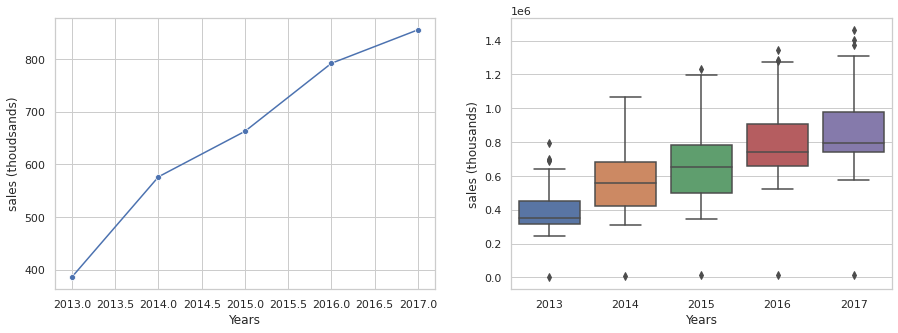

In [ ]:
# Line and box plot for annual sales values
f, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(x = table_y.index , y='mean' , data=table_y , ax=axes[0], marker='o')
sns.boxplot(x='year', y='sales', data=df, ax=axes[1])

axes[0].set(xlabel='Years', ylabel='sales (thoudsands)')
axes[1].set(xlabel='Years', ylabel='sales (thousands)')

* Sales increase every year
* There are a lot of outliers in 2017

In [ ]:
# Sales values doesn't distributed normally
# Non-parametric Kruskal-Wallis H test
data = [df.loc[ids, 'sales'].values for ids in df.groupby('year').groups.values()]

H, p = ss.kruskal(*data)
alpha = 0.05

if p > alpha:
	print('population means of all groups are equal (fail to reject H0)')
else:
	print('population means of all groups are not equal (reject H0)')

# We may reject the null hypothesis that the population medians of all of the groups are equal. 

population means of all groups are not equal (reject H0)


In [ ]:
# post hoc tests
import scipy.stats as ss
import statsmodels.api as sa
import scikit_posthocs as sp

sp.posthoc_conover(df, val_col='sales', group_col='year', p_adjust = 'holm').round()

# There is statistical significant difference between months.

,2013,2014,2015,2016,2017
2013,1.0,0.0,0.0,0.0,0.0
2014,0.0,1.0,0.0,0.0,0.0
2015,0.0,0.0,1.0,0.0,0.0
2016,0.0,0.0,0.0,1.0,0.0
2017,0.0,0.0,0.0,0.0,1.0


There are significant different between each pair of years

##**2.3.Correlations between sales and other continuous features**

In [ ]:
# sales correlation for each separate year
list = []
for year in range(2013, 2018):
  list.append(df[df['year']==year].corr().iloc[6])

df_corrs = pd.DataFrame(list).T
df_corrs.columns = [2013, 2014,2015,2016,2017]
df_corrs = df_corrs.iloc[[0,1,2,3,4,5,11]]
df_corrs

,2013,2014,2015,2016,2017
exxon_price,0.363303,-0.286795,-0.507346,0.069317,0.013506
oil,0.040300,-0.534870,-0.329255,0.121009,0.012387
CPI,NaN,NaN,NaN,NaN,NaN
GDPPCAP,NaN,NaN,NaN,NaN,NaN
POP,NaN,NaN,NaN,NaN,NaN
transactions,0.894882,0.706734,0.720982,0.775438,0.867778
month,0.367412,0.397916,0.666327,0.163442,0.023654


add average value of transaction and do ANOVA test for dummy variables

In [ ]:
# Correlation for each quarter (include all years)
list_1 =[]

list = []
for quarter in range(1,5):
  list.append(df[df['quarter']==quarter].corr().iloc[6])

df_corrs = pd.DataFrame(list).T
df_corrs.columns = ['Q1','Q2','Q3','Q4']
df_corrs = df_corrs.iloc[[0,1,2,3,4,5,11]]
df_corrs

,Q1,Q2,Q3,Q4
exxon_price,0.065726,-0.117617,-0.103365,0.006992
oil,-0.480254,-0.727745,-0.696845,-0.674005
CPI,-0.579416,-0.596710,-0.255314,-0.017680
GDPPCAP,0.143986,-0.131615,0.050351,0.088343
POP,0.709013,0.779028,0.721510,0.645624
transactions,0.636127,0.742914,0.766174,0.666069
month,0.031458,0.042845,-0.050519,0.295086


In [ ]:
# The correlation between sales and other features

# Create a dataframe for correlation by year.
df_cor = pd.DataFrame(df_annual.corr(method ='pearson').iloc[6])
df_cor.reset_index(inplace=True)
df_cor.columns = ['attributes', 'corr_coef_annual']

# Create a dataframe for correlation by semi-year.
df_cor_semi = pd.DataFrame(df.resample(rule='2BQ').mean().corr(method ='pearson').iloc[6])
df_cor_semi.reset_index(inplace=True)
df_cor_semi.columns = ['attributes', 'corr_coef_semi_annual']

# Merge two dataframes
df_cor = df_cor.merge(df_cor_semi, on='attributes')
df_cor = df_cor.iloc[[0,1,2,3,4]]
# Drop meaningless attributes: day, month, year, sales, salary day, transactions, week_days, value_per_transaction, day_off

df_cor

,attributes,corr_coef_annual,corr_coef_semi_annual
0,exxon_price,0.071239,0.009675
1,oil,-0.873733,-0.902872
2,CPI,-0.614548,-0.574912
3,GDPPCAP,0.076307,0.003024
4,POP,0.978198,0.974436




*   GDPPCAP and exxon_price have close to 0 correlations with sales across all levels, hence we can drop these features



[Text(0.5, 1.0, 'Heatmap for Semi-Annual Data')]

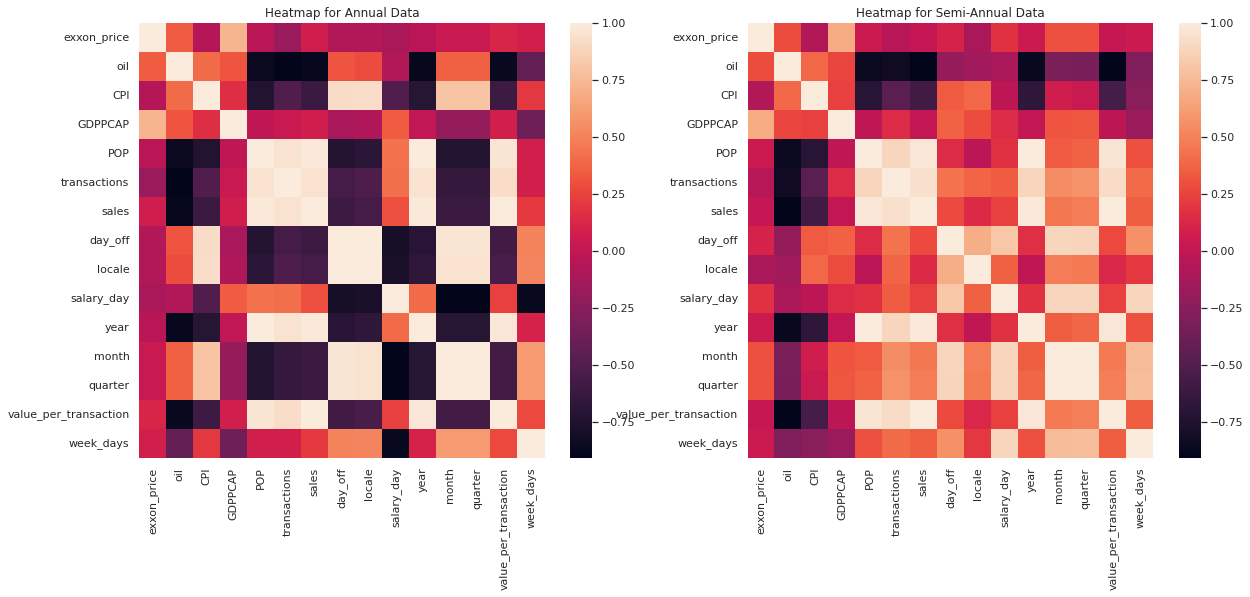

In [ ]:
# Plot heatmap both annual and semi-annual data
f, axes = plt.subplots(1, 2, figsize=(20,8))
sns.heatmap(df_annual.corr(method ='pearson'), ax=axes[0]).set(title='Heatmap for Annual Data')
sns.heatmap(df.resample(rule='2BQ').mean().corr(method ='pearson'), ax=axes[1]).set(title='Heatmap for Semi-Annual Data')

According to heatmap and correlation coefficient dataframe,

There is a **positive** relationship (r > .5) between sales and the attributes listed below:
* Population

There is a **negative** relationship (r < - .5) between sales and the attributes listed below:
* Oil
* CPI



In [ ]:
# define a function to create scatterplots of sales against other attributes
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'sales', data=df_annual, alpha=0.5)
        ax.set(xlabel=col, ylabel='sales')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [ ]:
features = [shi_data for shi_data in df_annual.columns]

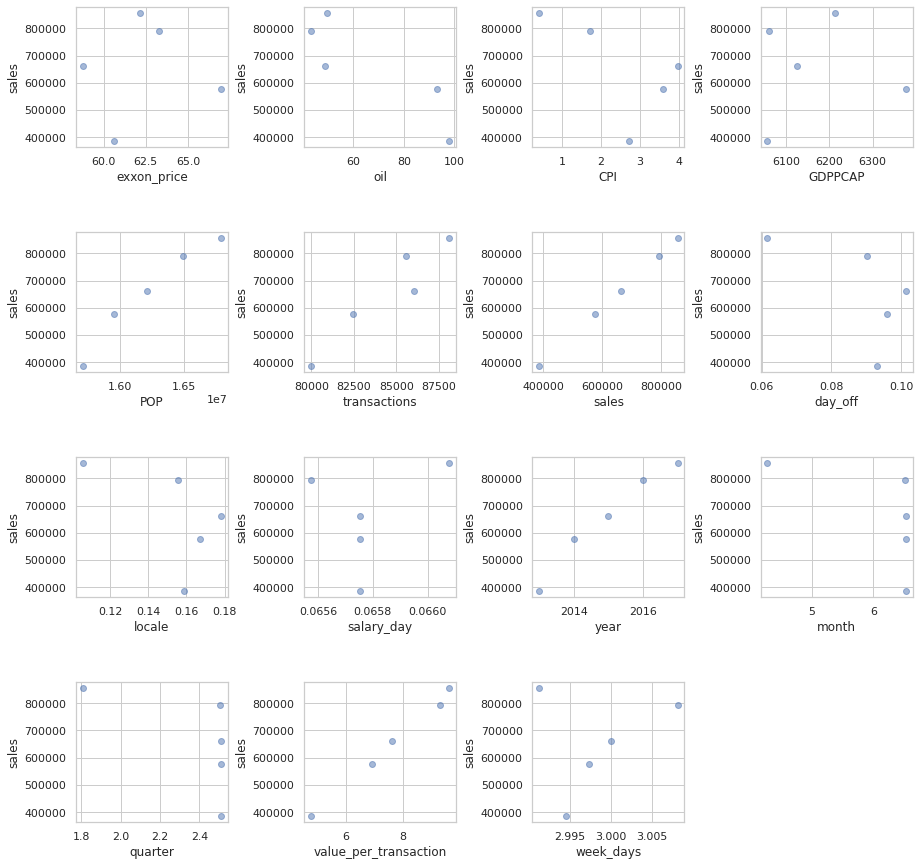

In [ ]:
# scatter plot for sales and every attributes
scatterplots(features, ncol=4, figsize=(15, 15))

##**2.4. ANOVA test for categorical variables**

In [ ]:
#Test the normality of sales
from scipy import stats
k2, p = stats.normaltest(df.sales)
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

The null hypothesis can be rejected


In [ ]:
#Sales doesn't follow a normal distribution, use kruskal wallis test
from scipy.stats.mstats import kruskal

#Define kruskal wallis test function 
def kw_test(col):
  H, pval = kruskal(*[group["sales"].values for name, group in df.groupby(col)])
  print("H-statistic:", H)
  print("P-Value:", pval)
  if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
  if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")
  sns.boxplot(x=col, y='sales', data=df)

H-statistic: 0.5759990254375297
P-Value: 0.4478848623532148
Accept NULL hypothesis - No significant difference between groups.


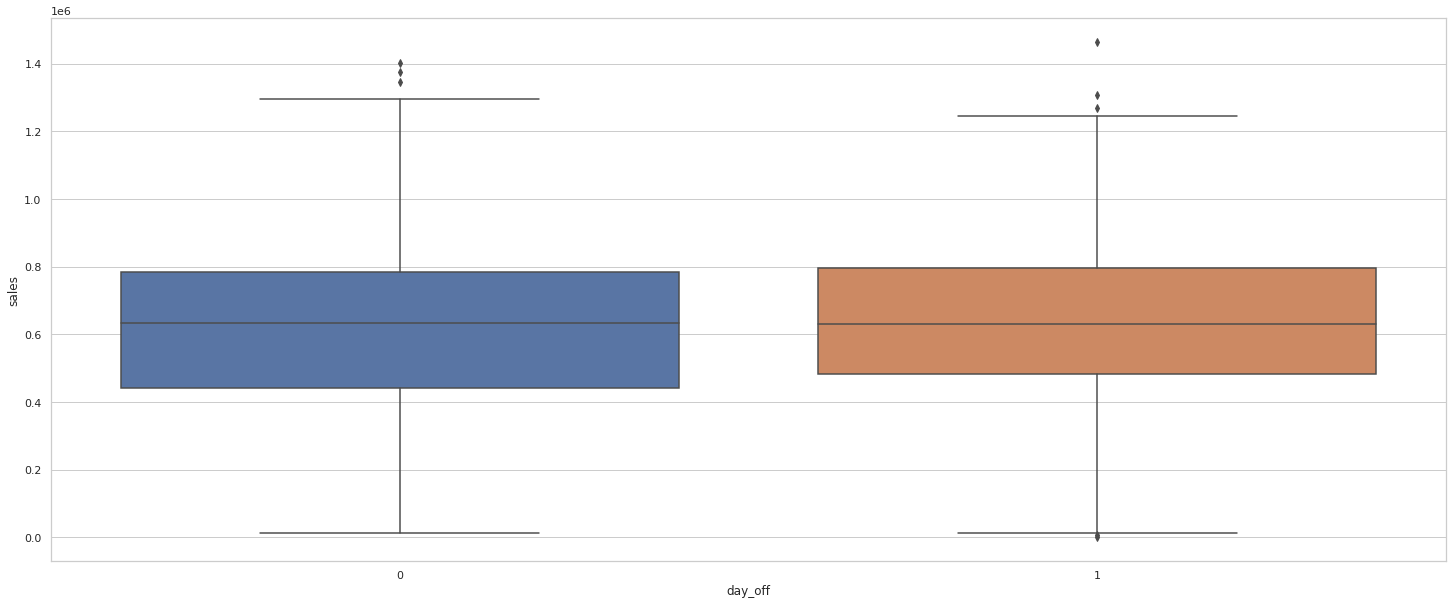

In [ ]:
#KW test for day_off
kw_test('day_off')

H-statistic: 0.2393718863052612
P-Value: 0.6246601400250473
Accept NULL hypothesis - No significant difference between groups.


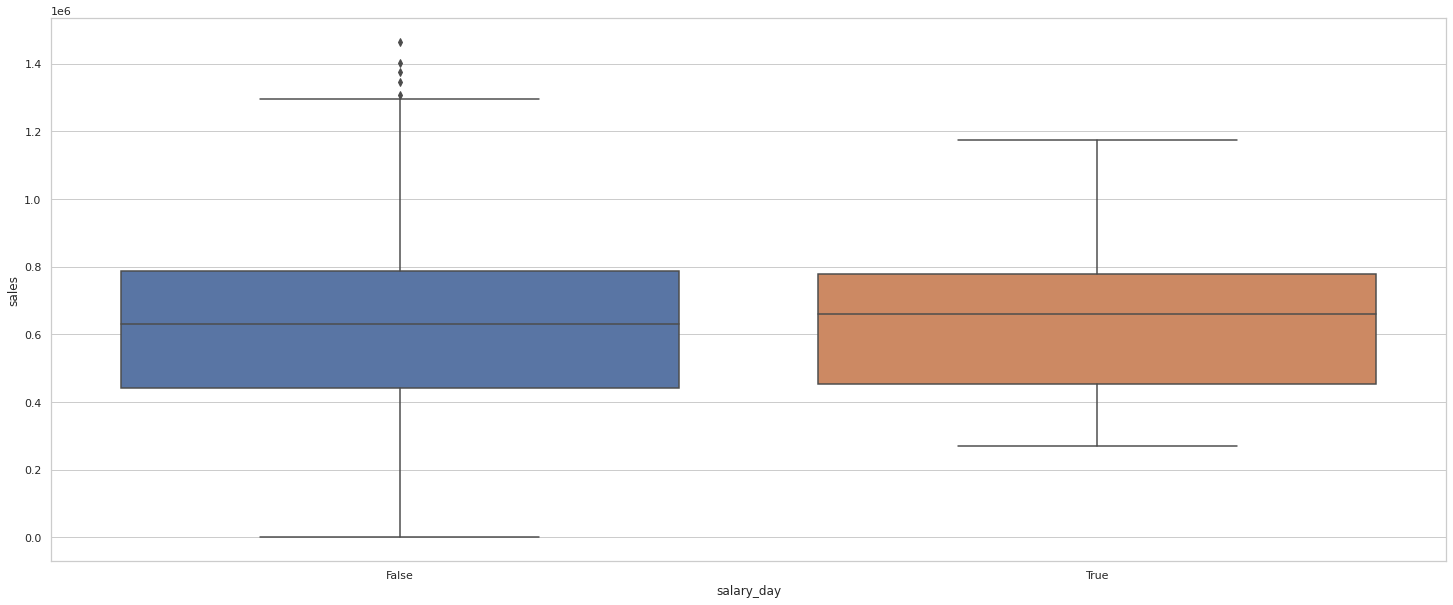

In [ ]:
#KW test for salary_day
kw_test('salary_day')

H-statistic: 0.8619070910634373
P-Value: 0.8346093859687279
Accept NULL hypothesis - No significant difference between groups.


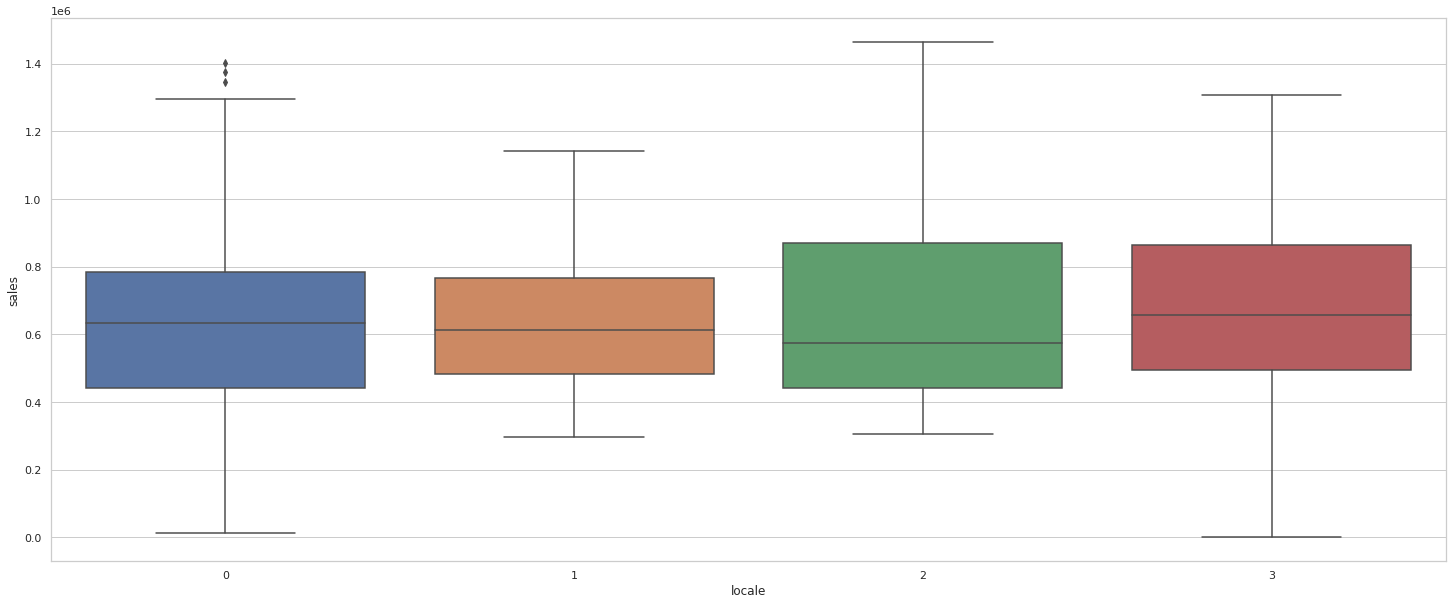

In [ ]:
#KW test for holiday by locale
kw_test('locale')

## **2.5. Time Plots for sales and Highly Correlated Attributes**

###**2.5.1.Sales and Population**

Before plotting the changes in sales and population, I want to scale dataframe because there is scale difference between two attributes. Plotting without scaling, sales values seem to be constant because sales values are very small compared to population values. 

**PS**: Scaling does not affect the correlation coefficient.

In [ ]:
# get column names and index of df because scaling creates an array.
df_scaled_index = df.index

In [ ]:
# df.drop(['date'], axis = 1, inplace = True)
df_scaled_columns = df.columns

In [ ]:
# scale the df
df_scaled = scale(df)
#create a df from scaled array
df_scaled=pd.DataFrame(df_scaled, columns=df_scaled_columns, index=df_scaled_index)
df_scaled.head()

,exxon_price,oil,CPI,GDPPCAP,POP,transactions,sales,day_off,locale,salary_day,year,month,quarter,value_per_transaction,week_days
date,,,,,,,,,,,,,,,
2013-01-01,-0.931025,0.983096,0.057513,-0.856491,-1.322369,-6.793045,-2.706704,3.167441,5.020031,-0.265305,-1.365737,-1.538759,-1.283954,-1.742199,-0.999408
2013-01-02,-0.931025,0.983096,0.057513,-0.856491,-1.322369,0.741830,-0.605631,-0.315712,-0.277205,-0.265305,-1.365737,-1.538759,-1.283954,-0.890748,-0.499408
2013-01-03,-0.956780,0.976472,0.057513,-0.856491,-1.322369,-0.457213,-1.178728,-0.315712,-0.277205,-0.265305,-1.365737,-1.538759,-1.283954,-1.187348,0.000592
2013-01-04,-0.890799,0.982317,0.057513,-0.856491,-1.322369,-0.458028,-1.208533,-0.315712,-0.277205,-0.265305,-1.365737,-1.538759,-1.283954,-1.223971,0.500593
2013-01-05,-0.890799,0.982317,0.057513,-0.856491,-1.322369,0.771010,-0.685413,-0.315712,-0.277205,-0.265305,-1.365737,-1.538759,-1.283954,-0.981944,1.000593


In [ ]:
# create quarterly data from scaled dataframe
df_scaled_quarterly = df_scaled.resample(rule='QS').mean()

# plot
fig =  px.line(df_scaled_quarterly, x=df_scaled_quarterly.index, y=['sales', 'POP'], title='Sales and Population with slider', markers='o')
fig.update_xaxes(
    rangeslider_visible=True)
fig.show()

###**2.5.2. Sales and CPI**

In [ ]:
import plotly.express as px

fig =  px.line(df_scaled_quarterly, x=df_scaled_quarterly.index, y=['sales', 'CPI'], 
               title='Sales and CPI with slider',
               markers='o')
fig.update_xaxes(
    rangeslider_visible=True)
fig.show()

###**2.5.3. Sales and Oil Prices**

In [ ]:
import plotly.express as px

fig =  px.line(df_scaled_quarterly, x=df_scaled_quarterly.index, y=['sales', 'oil'], 
               title='Sales and Oil Price with slider',
               markers="o")
fig.update_xaxes(
    rangeslider_visible=True)
fig.show()

##**2.6. Stationarize the Data**

Why is this important? When running a linear regression the assumption is that all of the observations are all independent of each other. In a time series, however, we know that observations are time dependent. It turns out that a lot of nice results that hold for independent random variables (law of large numbers and central limit theorem to name a couple) hold for stationary random variables. So by making the data stationary, we can actually apply regression techniques to this time dependent variable.

###**2.6.1. Stationarize Daily Data**

In [ ]:
# Determining rolling statistics
rollmean = df.sales.rolling(window=365).mean()
rollstd = df.sales.rolling(window=365).std()

In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, rolmean, rolstd):

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 
    print('p-value < 5%: '+ str(dfoutput[1] < 0.005))
    

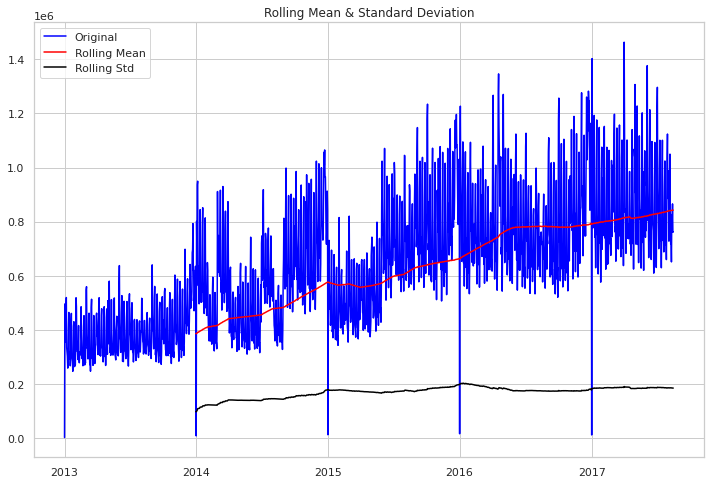

Results of Dickey-Fuller Test:
Test Statistic                   -2.623339
p-value                           0.088269
#Lags Used                       22.000000
Number of Observations Used    1665.000000
Critical Value (1%)              -3.434284
Critical Value (5%)              -2.863277
Critical Value (10%)             -2.567695
dtype: float64
p-value < 5%: False


In [ ]:
test_stationarity(df.sales, rollmean, rollstd)

**H$_0$**: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.

**H$_A$**: The time series is stationary.

The p-value from the test is larger than .05, we cannot reject the null hypothesis. The first thing we want to do is take the first difference of the data. Perhaps the statistics of the changes in the series between periods or between seasons will be constant. This should help to eliminate the overall trend from the data.



In [ ]:
# Get the difference
df['sales_diff_1'] = df.sales.diff(1)
# We don't want NaNs
df['sales_diff_1'].iloc[1:].head()

date
2013-01-02    493580.798945
2013-01-03   -134631.186820
2013-01-04     -7001.554031
2013-01-05    122890.444136
2013-01-06     42345.279859
Name: sales_diff_1, dtype: float64

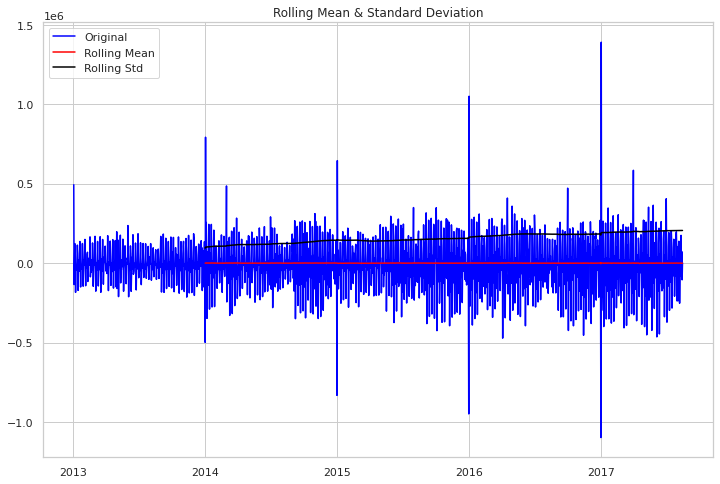

Results of Dickey-Fuller Test:
Test Statistic                -1.135113e+01
p-value                        9.988955e-21
#Lags Used                     2.500000e+01
Number of Observations Used    1.661000e+03
Critical Value (1%)           -3.434293e+00
Critical Value (5%)           -2.863282e+00
Critical Value (10%)          -2.567697e+00
dtype: float64
p-value < 5%: True


In [ ]:
# Determining rolling statistics
rollmean = df.sales_diff_1.rolling(window=365).mean()
rollstd = df.sales_diff_1.rolling(window=365).std()
test_stationarity(df.sales_diff_1.iloc[1:], rollmean, rollstd)

Taking the first difference makes the data stationary (p-value < 5%)

###**2.6.2. Stationarize Monthly Data**

In [ ]:
# Determining rolling statistics
rollmean = df_monthly.sales.rolling(window=12).mean()
rollstd = df_monthly.sales.rolling(window=12).std()

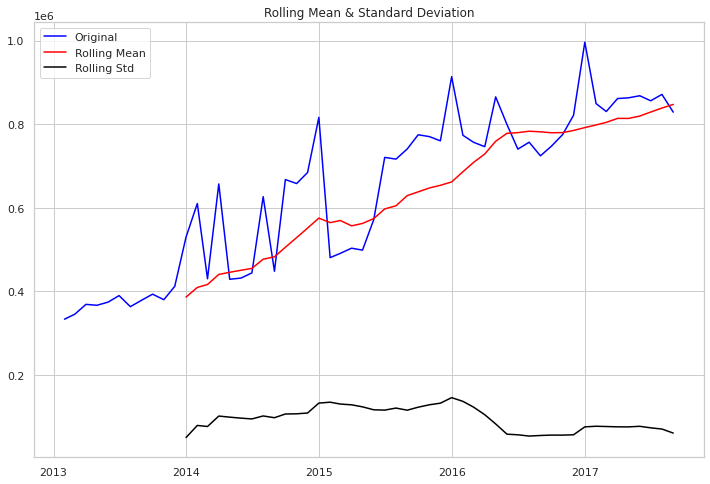

Results of Dickey-Fuller Test:
Test Statistic                 -1.587685
p-value                         0.489777
#Lags Used                      1.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64
p-value < 5%: False


In [ ]:
test_stationarity(df_monthly.sales, rollmean, rollstd)

We cannot reject the null hypothesis

In [ ]:
# Get the difference
df_monthly['sales_diff_1'] = df_monthly.sales.diff(1)
# We don't want NaNs
df_monthly['sales_diff_1'].iloc[1:].head()

date
2013-02-28    11813.664133
2013-03-31    23698.345563
2013-04-30    -2212.370157
2013-05-31     7670.659497
2013-06-30    15525.317977
Freq: M, Name: sales_diff_1, dtype: float64

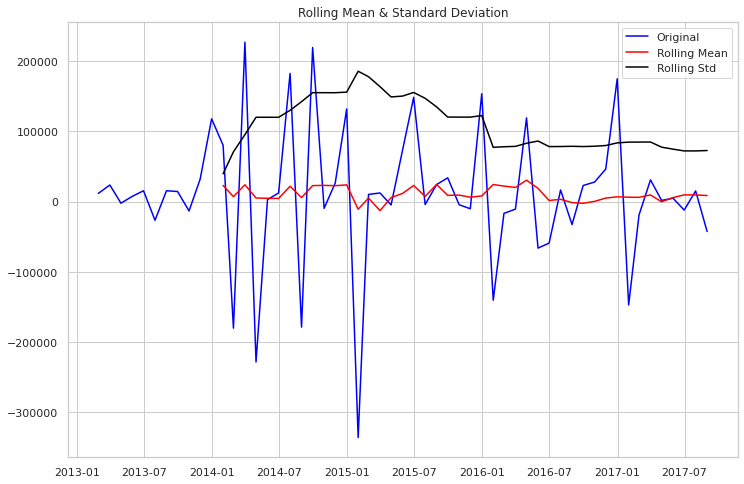

Results of Dickey-Fuller Test:
Test Statistic                -1.165452e+01
p-value                        2.000208e-21
#Lags Used                     0.000000e+00
Number of Observations Used    5.400000e+01
Critical Value (1%)           -3.557709e+00
Critical Value (5%)           -2.916770e+00
Critical Value (10%)          -2.596222e+00
dtype: float64
p-value < 5%: True


In [ ]:
# Determining rolling statistics
rollmean = df_monthly.sales_diff_1.rolling(window=12).mean()
rollstd = df_monthly.sales_diff_1.rolling(window=12).std()
test_stationarity(df_monthly.sales_diff_1.iloc[1:], rollmean, rollstd)

Taking the first difference stationarizes the monthly data

##**2.7. Lag Plots**

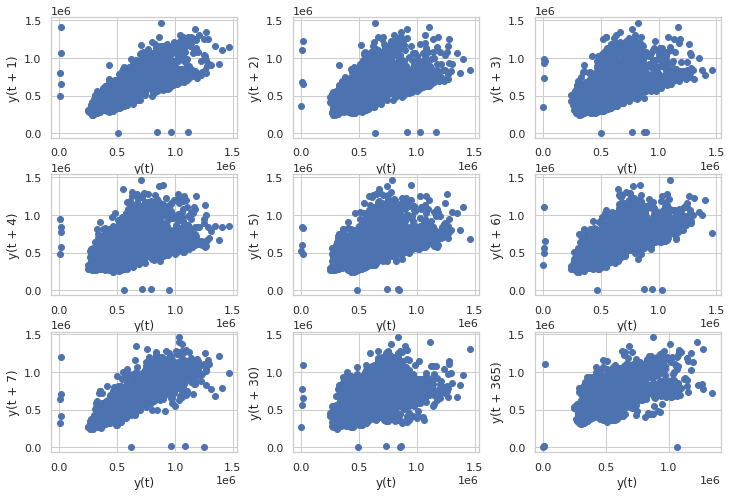

In [ ]:
# lag plot for daily data
fig , ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7,ax8, ax9)) = plt.subplots(3,3, figsize=(12,8))
fig.subplots_adjust(hspace = .3, wspace= .3)
lag_plot(df.sales, lag=1, ax = ax1)
lag_plot(df.sales, lag=2, ax = ax2)
lag_plot(df.sales, lag=3, ax = ax3)
lag_plot(df.sales, lag=4, ax = ax4)
lag_plot(df.sales, lag=5, ax = ax5)
lag_plot(df.sales, lag=6, ax = ax6)
lag_plot(df.sales, lag=7, ax = ax7)
lag_plot(df.sales, lag=30, ax = ax8)
lag_plot(df.sales, lag=365, ax = ax9)

##**2.8. Autocorrelation and Partial Autocorrelation** 

**Autocorrelation** is the correlation of a single time series with a lagged copy of itself.
These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps.

<Figure size 360x216 with 0 Axes>

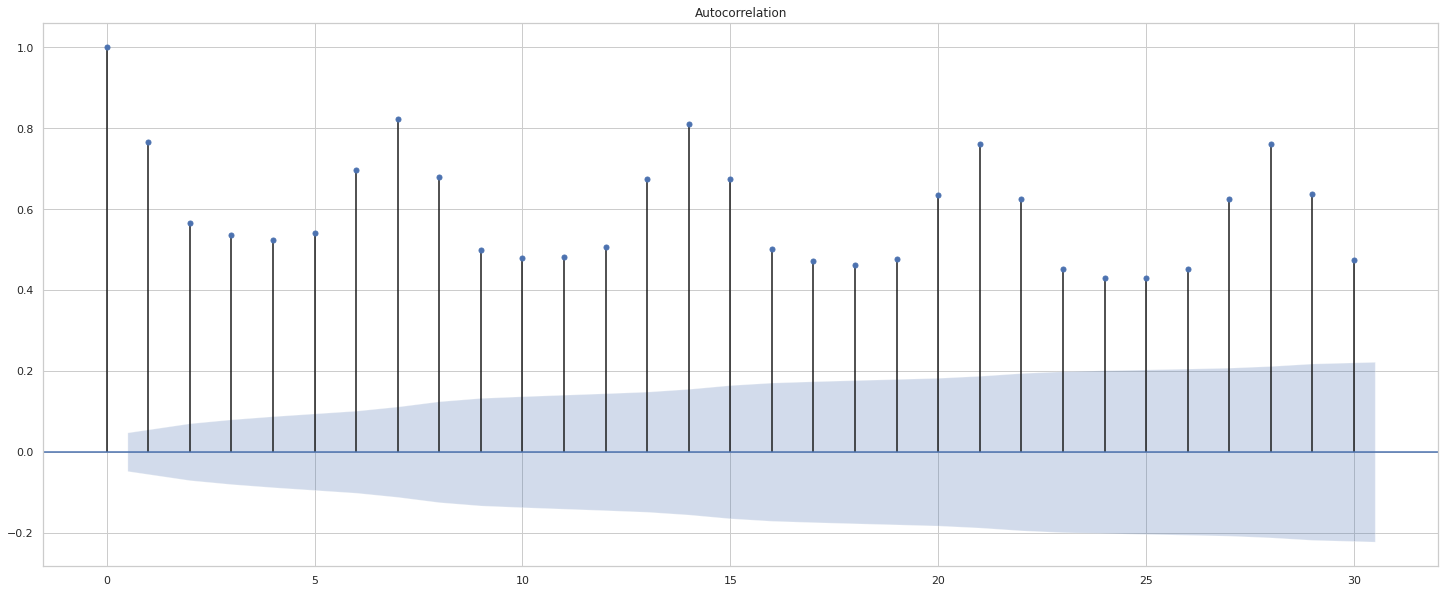

In [ ]:
from statsmodels.tsa.stattools import acf
# Lag plots for daily data
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(5,3))
plot_acf(df.sales, lags = 30)
plt.show()

<Figure size 360x216 with 0 Axes>

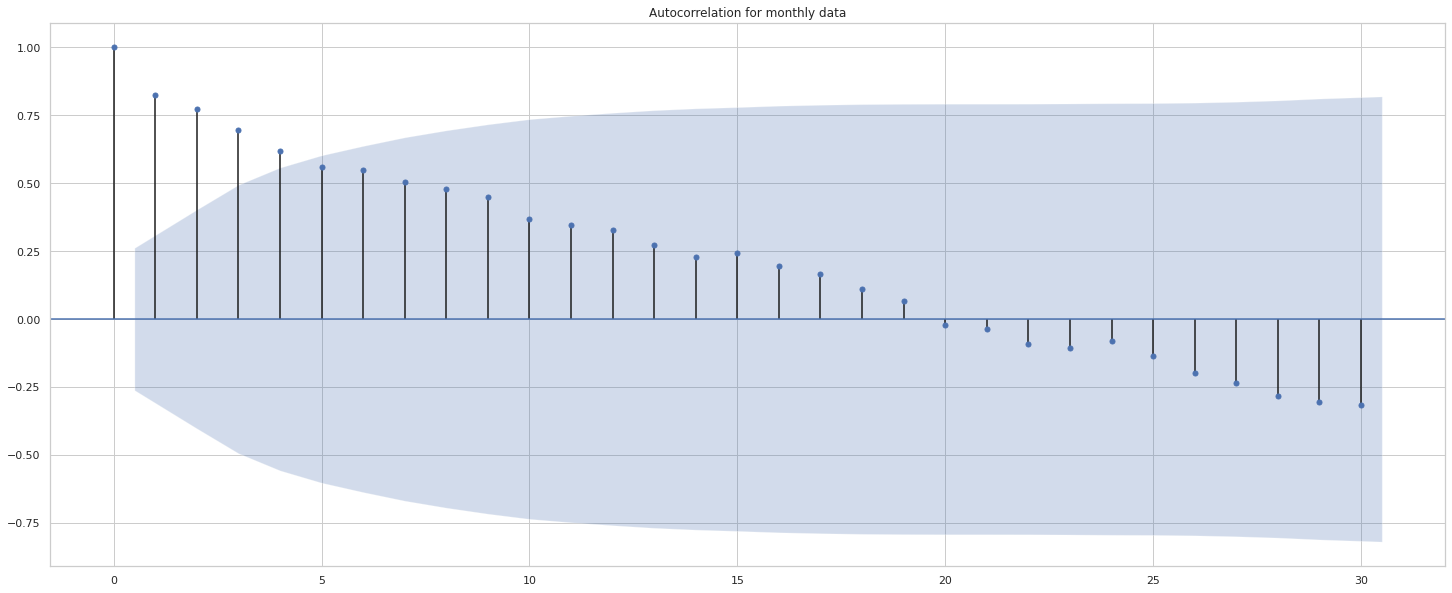

In [ ]:
# Lag plots for monthly data
plt.figure(figsize=(5,3))
plot_acf(df_monthly.sales, lags=30, title='Autocorrelation for monthly data')
plt.show()

A **partial autocorrelation** is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed. We can see the direct impact a previous observation has on the value to be predicted at a time.

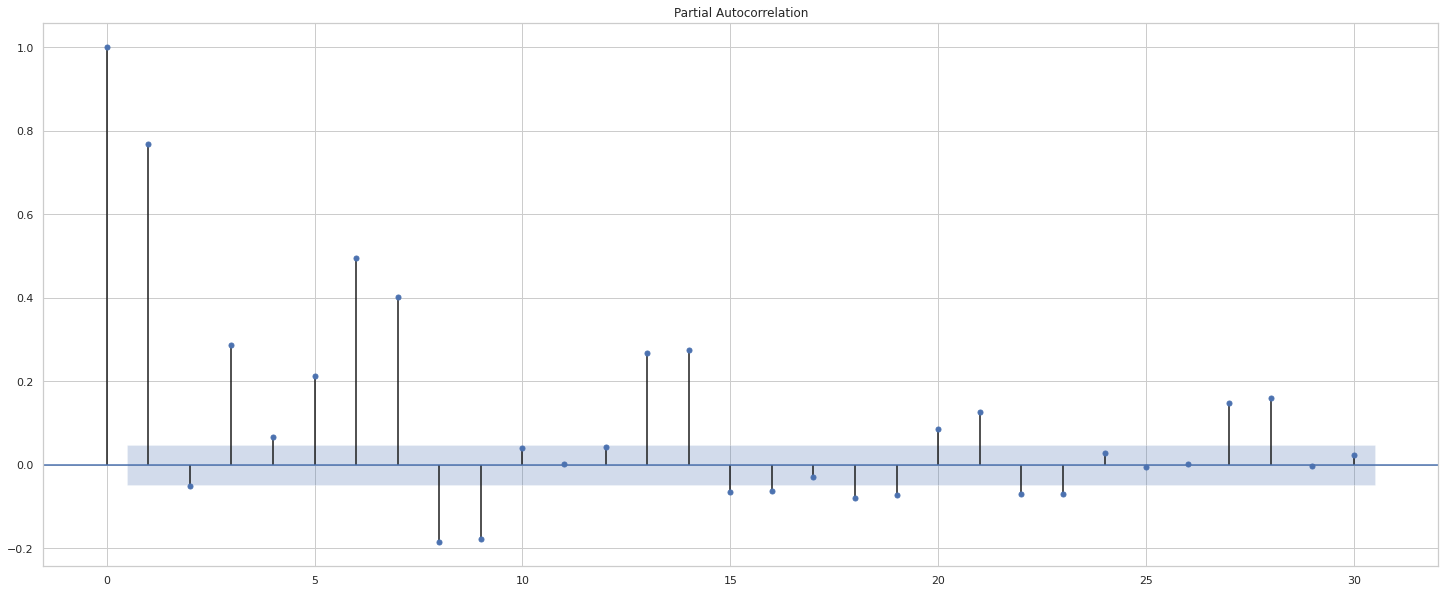

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df.sales, lags=30)
plt.show()

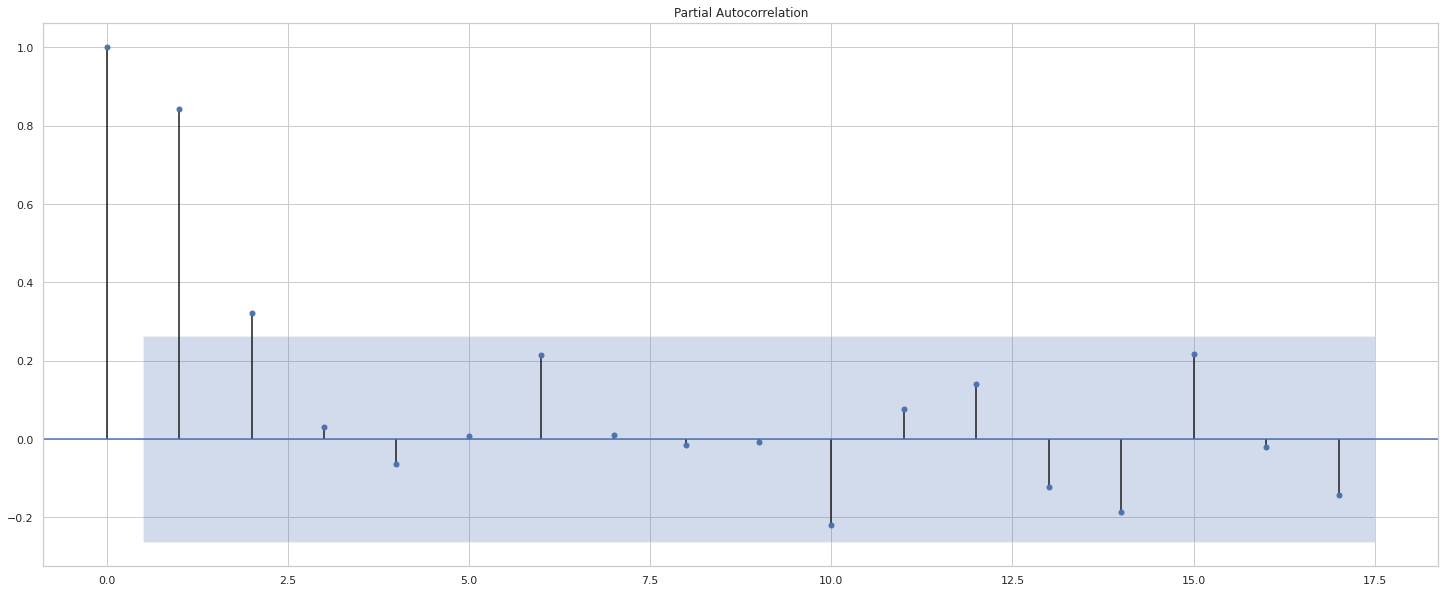

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_monthly.sales, lags=17)
plt.show()